In [1]:
import torch
import utility
import os
import yaml
import glob
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from model import common
import torch.nn as nn
import for_demo
from importlib import import_module

In [2]:
name = 'test/test_rdn-cret+.yaml'
with open(os.path.join('configs', name), 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    print('config loaded, config_path: {}'.format(os.path.join('configs', name)))

module = import_module("model." + config["model"]["name"].lower())
net = module.make_model(config).to('cuda')
load_from = torch.load('rdn_cret+.pt')
net.load_state_dict(load_from, strict=True)

filtering = common.Filtering(config)
squeezing = for_demo.sino_patching(config)

img = torch.from_numpy(np.load('demo_img.npy')).unsqueeze(0).unsqueeze(0)
sinogram = torch.from_numpy(np.load('demo_sino.npy')).unsqueeze(0).unsqueeze(0)

config loaded, config_path: configs/test/test_rdn-cret+.yaml


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
u_water = 0.0192867
d_beta = np.pi * 2 / config['model']['ct']['view']

y_ind, x_ind = 240, 355
patch_size = 48
bin_scale = 1
up_scale = 2

net.eval()
net.patch_size = int(patch_size*up_scale)

mask_idx = torch.Tensor([y_ind, x_ind]).long()
grid, square_patch = for_demo.BP_grid_patch(config['model']['ct'], mask_idx, int(patch_size * up_scale), up_scale)
grid, square_patch = grid.cuda(), square_patch.cuda()

sino = F.avg_pool2d(sinogram.cuda(), kernel_size=(1,bin_scale), stride=(1,bin_scale)) * bin_scale #detector binning
sino = -torch.log(sino / 1e6 / bin_scale)

if config['dataset']['squeezing']:
    sino = F.pad(sino,(64//bin_scale,64//bin_scale,0,0))

sino = utility.normalize(sino, 0, 1)

sino = filtering(sino, bin_scale)
sino_patch, grid_patch = squeezing(sino, grid.clone().unsqueeze(0), mask_idx, bin_scale)
recon = net(sino_patch, grid_patch, square_patch.unsqueeze(0), bin_scale)
        
recon = utility.denormalize(recon, 0, 1 * d_beta).detach().cpu()
recon = (recon - 0.0192867) * 1000 / 0.0192867  # mm-1 to HU

# recon_dual = utility.denormalize(recon_dual, 0, 1 * d_beta).detach().cpu()
# recon_dual = (recon_dual - 0.0192867) * 1000 / 0.0192867  # mm-1 to HU

## FBP recon as x2
temp = F.grid_sample(sino_patch, grid_patch, mode = "bilinear", align_corners=False)
fbp = torch.sum(temp[:, temp.shape[1]//2, :, :] * square_patch.unsqueeze(0) * 10000, dim=-2).cpu().view(1,1,int(patch_size*up_scale),int(patch_size*up_scale)) * d_beta
fbp = (fbp - 0.0192867) * 1000 / 0.0192867  # mm-1 to HU

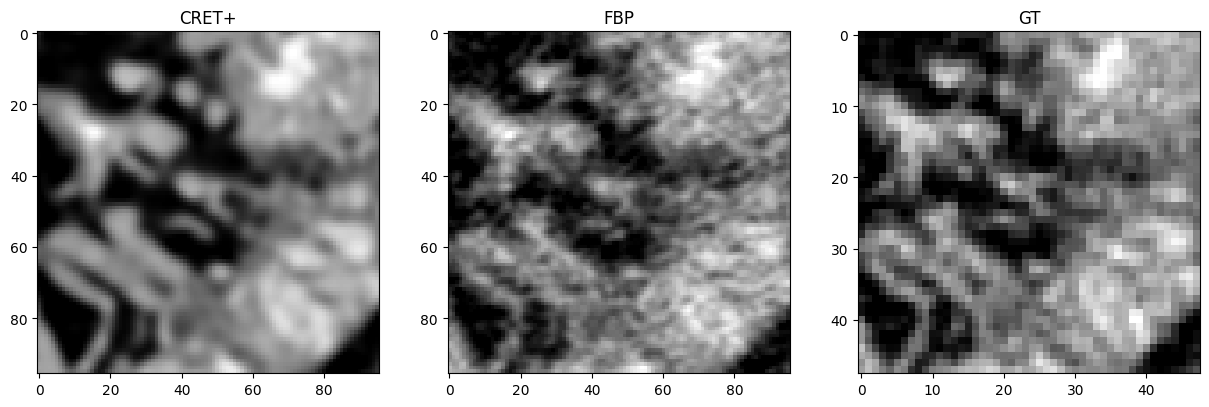

In [6]:
img_patch = img.squeeze()[y_ind-patch_size//2+1:y_ind+patch_size//2+1, x_ind-patch_size//2+1:x_ind+patch_size//2+1]-1024
disp_window = [-80, 320]

fig, axs = plt.subplots(1, 3, figsize=(15, 45))
axs[0].set_title("CRET+")
axs[1].set_title("FBP")
axs[2].set_title("GT")
axs[0].imshow(recon.squeeze(), cmap='gray', vmin=disp_window[0], vmax=disp_window[1])
axs[1].imshow(fbp.squeeze(), cmap='gray', vmin=disp_window[0], vmax=disp_window[1])
axs[2].imshow(img_patch, cmap='gray', vmin=disp_window[0], vmax=disp_window[1])